In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_path = '../data/DATASET/train'
test_path = '../data/DATASET/test'

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

In [2]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def train_epoch(model, loader, optimizer, loss_fn, device='cuda'):
    model.train()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        all_predictions.extend(output.argmax(1).cpu().detach().numpy())
        all_targets.extend(target.cpu().detach().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    f1_per_classes = f1_score(all_targets, all_predictions, average=None)
    
    return avg_loss, accuracy, f1, f1_per_classes

def evaluate_epoch(model, loader, loss_fn, device='cuda'):

    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = loss_fn(output, target)
            
            total_loss += loss.item()
            
            all_predictions.extend(output.argmax(1).cpu().detach().numpy())
            all_targets.extend(target.cpu().detach().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    f1_per_classes = f1_score(all_targets, all_predictions, average=None)
    
    return avg_loss, accuracy, f1, f1_per_classes

In [3]:
import matplotlib.pyplot as plt

def plot_history(history, class_names=None):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    ax1, ax2, ax3, ax4 = axes
    
    ax1.plot(epochs, history['train_loss'], label='Train Loss')
    ax1.plot(epochs, history['test_loss'], label='Test Loss')
    ax1.legend(); ax1.set_title('Loss')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss')
    
    ax2.plot(epochs, history['train_acc'], label='Train Acc')
    ax2.plot(epochs, history['test_acc'], label='Test Acc')
    ax2.legend(); ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy')
    
    ax3.plot(epochs, history['train_f1'], label='Train F1')
    ax3.plot(epochs, history['test_f1'], label='Test F1')
    ax3.legend(); ax3.set_title('F1 Score')
    ax3.set_xlabel('Epochs'); ax3.set_ylabel('F1 Score')
    if 'test_f1_per_class' in history and len(history['test_f1_per_class']) > 0:
        # Берем F1-scores из последней эпохи
        last_epoch_f1 = history['test_f1_per_class'][-1]
        
        # Создаем имена классов если не предоставлены
        if class_names is None:
            num_classes = len(last_epoch_f1)
            class_names = [f'Class {i}' for i in range(num_classes)]
        elif len(class_names) != len(last_epoch_f1):
            class_names = [f'Class {i}' for i in range(len(last_epoch_f1))]
        
        # Создаем гистограмму
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(last_epoch_f1)))
        bars = ax4.bar(range(len(last_epoch_f1)), last_epoch_f1, color=colors, edgecolor='black')
        
        # Добавляем значения
        for bar, value in zip(bars, last_epoch_f1):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)
        
        ax4.set_xlabel('Class')
        ax4.set_ylabel('F1 Score')
        ax4.set_xticks(range(len(class_names)))
        ax4.set_xticklabels(class_names, rotation=45, ha='right')
        ax4.set_ylim([0, 1.1])
        ax4.grid(True, alpha=0.3, axis='y')
    else:
        ax4.text(0.5, 0.5, 'No per-class F1 data', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('F1 Score per Class')
    
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


EPOCH 1/50
Epoch: 1, F1: 0.561

EPOCH 2/50
Epoch: 2, F1: 0.578

EPOCH 3/50
Epoch: 3, F1: 0.609

EPOCH 4/50

EPOCH 5/50
Epoch: 5, F1: 0.619

EPOCH 6/50
Epoch: 6, F1: 0.627

EPOCH 7/50

EPOCH 8/50

EPOCH 9/50

EPOCH 10/50
Epoch: 10, F1: 0.633

EPOCH 11/50

EPOCH 12/50
Epoch: 12, F1: 0.644

EPOCH 13/50

EPOCH 14/50

EPOCH 15/50

EPOCH 16/50

EPOCH 17/50

EPOCH 18/50

EPOCH 19/50

EPOCH 20/50

EPOCH 21/50

EPOCH 22/50

EPOCH 23/50

EPOCH 24/50

EPOCH 25/50

EPOCH 26/50

EPOCH 27/50

EPOCH 28/50
Epoch: 28, F1: 0.646

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50

EPOCH 34/50

EPOCH 35/50

EPOCH 36/50

EPOCH 37/50

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH 48/50

EPOCH 49/50

EPOCH 50/50
Best model: Epoch 28, F1: 0.646
Проверка данных:
Train loss: [1.3593016754214962, 1.1403243433063228, 1.057097669225186, 1.0091098399522405, 0.9777682034764439, 0.9453623224981129, 0.9343343818715

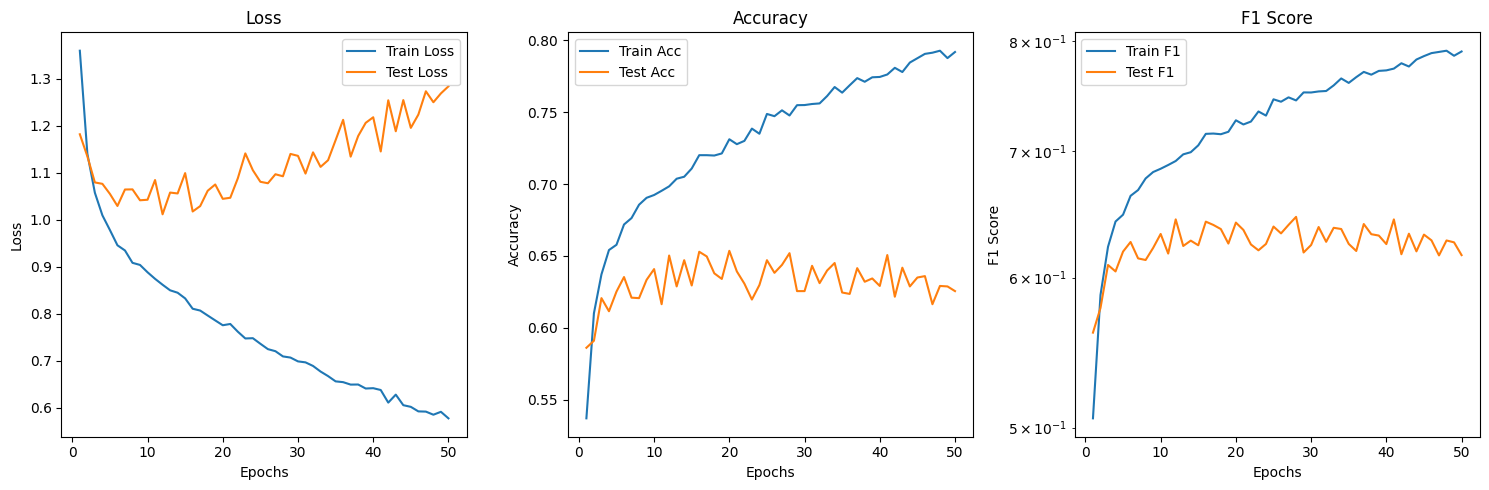

In [8]:
import torch.nn as nn
import torch.optim as optim
import torch as torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#создание простой модели
class SimpleFcModel(nn.Module):
    #инитиализация
    def __init__(self, num_classes, img_size):
        super().__init__()

        #присвоение размера картинок
        H, W = img_size
        input_dim = 1 * H * W
        self.flatten = nn.Flatten() #преобразование в вектор
        self.fc1 = nn.Linear(input_dim, 512) # линейный слой. На вход принимает набор чисел с размерностью 1* H * W. На выход отдает 512 параметров
        self.relu = nn.ReLU() #слой активатор. Все отрицательные числа приравнивает к 0, а положительные остаються положительными
        self.fc2 = nn.Linear(512, num_classes) #тоже самое. Только на вход принимает 512 парметров, а на выходе даёт num_classes(На выходе будут 7)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x


#инициализируем размер изображения и саму модель
img_size = (100, 100)
model = SimpleFcModel(7, img_size).to(device)

 #добавляем оптимизаторы
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#переменные для кол-ва эпох и оценки
n_epoch = 50
best_f1 = 0.0

#история для создания графика
history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": []
}

#сам цикд обучения и цикл оценки
for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1 = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)

Ответы на вопросы:
1.До flatten [32, 1, 100, 100]. После flatten[32, 10000]
На первом Linear in_features будет 10000. Число такое, потому что умножаеться количевстов каналов (1) на размер(100 * 100). Получаеться 10000
2. Я использовал nn.CrossEntropyLoss. Loss-- это показатель модели то, как плохо предсказывает, чем меньше этот показатель -- тем лучше модель справляеться с данными. Наша задача минимизировать loss, т.к. при его минимизации растёт процент точности модели. Loss можно плавно изменять, в то время как accyracy делает резкие скачки по графику.
3. Стоит оптимизатор Adam, а lr 1e-4.
Loss -- это потеря, которуюнужно минимизировать.
Градиент -- Минимизирует loss rate
Optimizer -- Адаптирует скорость обучения
Learning Rate -- контролирует шаг модели в оптимизации
4. Процесс переобучения начался между 10 и 20 жпохой, когда тестовые метрики начали хаотично падать и расти, в конце концов тестовая метрика находилась в приближенных значениях 60 - 63 процентов
5. Модель сохранила веса с 26 эпохи(не в ноутбуке модель сохранена с 13 эпохи). Веса с 50 эпохи к концу обучения падали и переучивались, в то время как веса с 8 эпохи остались лучшими, т.к. не подвергались переобучению.

Оценка модели(модель будет с папки models, лучшие метрики были в 13 эпохе)

In [ ]:

model.load_state_dict(torch.load('../models/best_model_fc.pth', map_location=device))
model.eval()
model.to(device)

NameError: name 'model' is not defined

In [12]:
test_iter = iter(test_loader)
images, labels = next(test_iter)

with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

print(f"Форма входных данных: {images.shape}")
print(f"Предсказанные классы: {predicted.cpu().numpy()}")
print(f"Истинные классы: {labels.numpy()}")

Форма входных данных: torch.Size([32, 1, 100, 100])
Предсказанные классы: [0 0 0 0 3 3 3 0 6 0 6 0 0 0 0 0 0 6 2 0 0 0 0 0 0 0 5 6 0 6 0 0]
Истинные классы: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Батч загрузил все фотографии с папки 1. Модель предсказала папку с точностью 68,75(22/32).Модель путает удивление со счастьем, с нейтральным настроением, с отвращением и со злостью. 

Ответы на вопросы:
Conv2d:
1. Слой Conv2d создает карту признаков для изображения. in_channesl -- это сколько каналов тдолжно входить в слой. В нашем случае in_channels -- 1. т.к. к изображениям был применён grayscale.
2. out_channesl -- Это то, сколько у нас будут ядер/фильтров, которые будут обрабатывать наш тензор. На выходе будет размер тензора [32, 16, Hm, Wm], где 32 -- размер батча, 16 -- out_channels, Hm, Hw -- размер изображения после преобразований. Каждый фильтр ищет определнный патерн изображения, из которых уже создаёться карта признаков.
3. kernel_size cоздает небольшое окно, которое скользит по тензору. Размер влияет на то, что "видит" модель. Так размер 3х3 идёт 9 весов на канал. Видит локальные контуры и контрасты
4. stride отвечает за шаг, с котрым будет идти фильтр, а padding добавляет к краям изображения пиксели.
Практика:
Hm = (H + 2 * padding - 1 *(kernel_size - 1) - 1)/stride + 1
Wm = (W + 2 * padding - 1 *(kernel_size - 1) - 1)/stride + 1
при расчётах размер вышел 100 на 100. Смотрим по коду
по коду вышел тензор [32, 32, 25, 25] Где первые 32 -- размер батча. вторые 32 -- карты признаков, 25 на 25 -- изображения после макспула.



EPOCH 1/50
Epoch: 1, F1: 0.494

EPOCH 2/50
Epoch: 2, F1: 0.590

EPOCH 3/50
Epoch: 3, F1: 0.618

EPOCH 4/50
Epoch: 4, F1: 0.626

EPOCH 5/50
Epoch: 5, F1: 0.660

EPOCH 6/50

EPOCH 7/50

EPOCH 8/50

EPOCH 9/50
Epoch: 9, F1: 0.676

EPOCH 10/50
Epoch: 10, F1: 0.691

EPOCH 11/50

EPOCH 12/50
Epoch: 12, F1: 0.694

EPOCH 13/50
Epoch: 13, F1: 0.696

EPOCH 14/50
Epoch: 14, F1: 0.700

EPOCH 15/50

EPOCH 16/50

EPOCH 17/50
Epoch: 17, F1: 0.703

EPOCH 18/50

EPOCH 19/50
Epoch: 19, F1: 0.707

EPOCH 20/50

EPOCH 21/50
Epoch: 21, F1: 0.716

EPOCH 22/50

EPOCH 23/50

EPOCH 24/50

EPOCH 25/50

EPOCH 26/50

EPOCH 27/50

EPOCH 28/50
Epoch: 28, F1: 0.717

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50

EPOCH 34/50

EPOCH 35/50

EPOCH 36/50

EPOCH 37/50

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH 48/50

EPOCH 49/50

EPOCH 50/50
Best model: Epoch 28, F1: 0.717


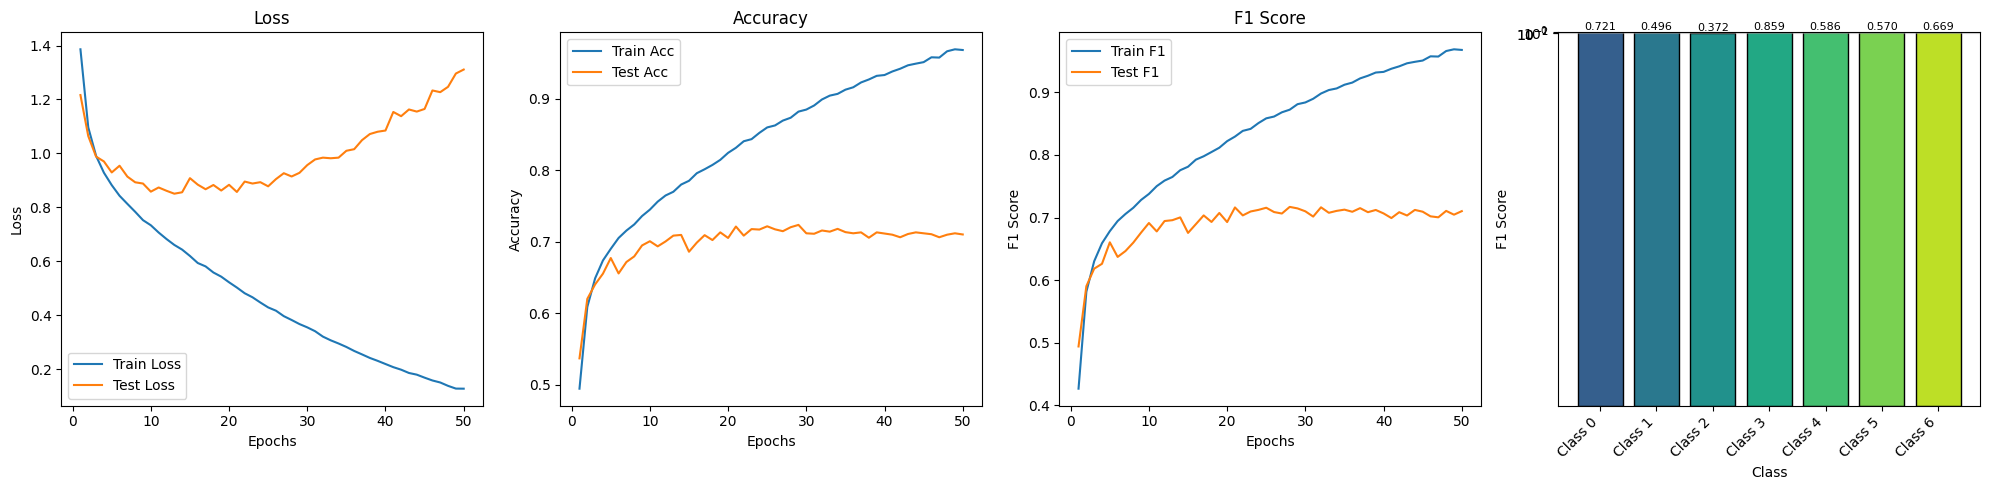

In [10]:
import torch.nn as nn
import torch.optim as optim
import torch as torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNNModel(nn.Module):
    # инициализация
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),#Делает карту принаков. Размер тензора (16, 100, 100)
            nn.ReLU(),#Слой активатор, все отрицательные веса становяться нулями
            nn.MaxPool2d(2, 2), #меняет размер тензора, размер становиться (16, 50, 50) 

            nn.Conv2d(16, 32, 3, 1, 1), # здесь размер тензора становиться (32, 50, 50)
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # а тут (32, 25, 25)
        )
        H = img_size[0] // 4
        W = img_size[1] // 4
        dim = 32 * H * W 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
img_size = (100, 100)
model = SimpleCNNModel(img_size, 7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#переменные для кол-ва эпох и оценки
n_epoch = 50
best_f1 = 0.0

#история для создания графика
history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": [],
    "test_f1_per_class": []
}

#сам цикд обучения и цикл оценки
for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1, train_f1_per_class = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1, test_f1_per_class = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)
    history["test_f1_per_class"].append(test_f1_per_class)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)

maxpool:
1. MaxPool берёт максимальное значение со своей области. У нас код с размером пула 2 на 2. Он уменьшает Hm и Wm в два раза. Он делит область картинки на сетки с размерностью 2 на 2 и выьирает из них максимальное значение.
2. Изменяет шейп только Hm и Wm. В нашем случае изменяет её в два раза.
3. Когда мы ужимаем признаки, мы делаем меньшее количевство параметров, при этом никак не влияем на качевство предсказаний. концептуально он обобщает признаки.
Практика:
1. по коду вышел тензор [32, 32, 25, 25] Где первые 32 -- размер батча. вторые 32 -- карты признаков, 25 на 25 -- изображения после макспула.
2. Расчет проходил по формуле 32 * H/4 * W/4 . Делили на 4, потому что у нас два слоя с maxpool 


EPOCH 1/50
Epoch: 1, F1: 0.464

EPOCH 2/50
Epoch: 2, F1: 0.570

EPOCH 3/50
Epoch: 3, F1: 0.611

EPOCH 4/50
Epoch: 4, F1: 0.618

EPOCH 5/50
Epoch: 5, F1: 0.648

EPOCH 6/50

EPOCH 7/50
Epoch: 7, F1: 0.663

EPOCH 8/50
Epoch: 8, F1: 0.667

EPOCH 9/50

EPOCH 10/50
Epoch: 10, F1: 0.687

EPOCH 11/50
Epoch: 11, F1: 0.695

EPOCH 12/50
Epoch: 12, F1: 0.702

EPOCH 13/50
Epoch: 13, F1: 0.706

EPOCH 14/50
Epoch: 14, F1: 0.709

EPOCH 15/50
Epoch: 15, F1: 0.712

EPOCH 16/50
Epoch: 16, F1: 0.716

EPOCH 17/50
Epoch: 17, F1: 0.722

EPOCH 18/50
Epoch: 18, F1: 0.727

EPOCH 19/50

EPOCH 20/50

EPOCH 21/50

EPOCH 22/50
Epoch: 22, F1: 0.731

EPOCH 23/50

EPOCH 24/50
Epoch: 24, F1: 0.732

EPOCH 25/50

EPOCH 26/50

EPOCH 27/50

EPOCH 28/50

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50

EPOCH 34/50
Epoch: 34, F1: 0.733

EPOCH 35/50

EPOCH 36/50

EPOCH 37/50

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH

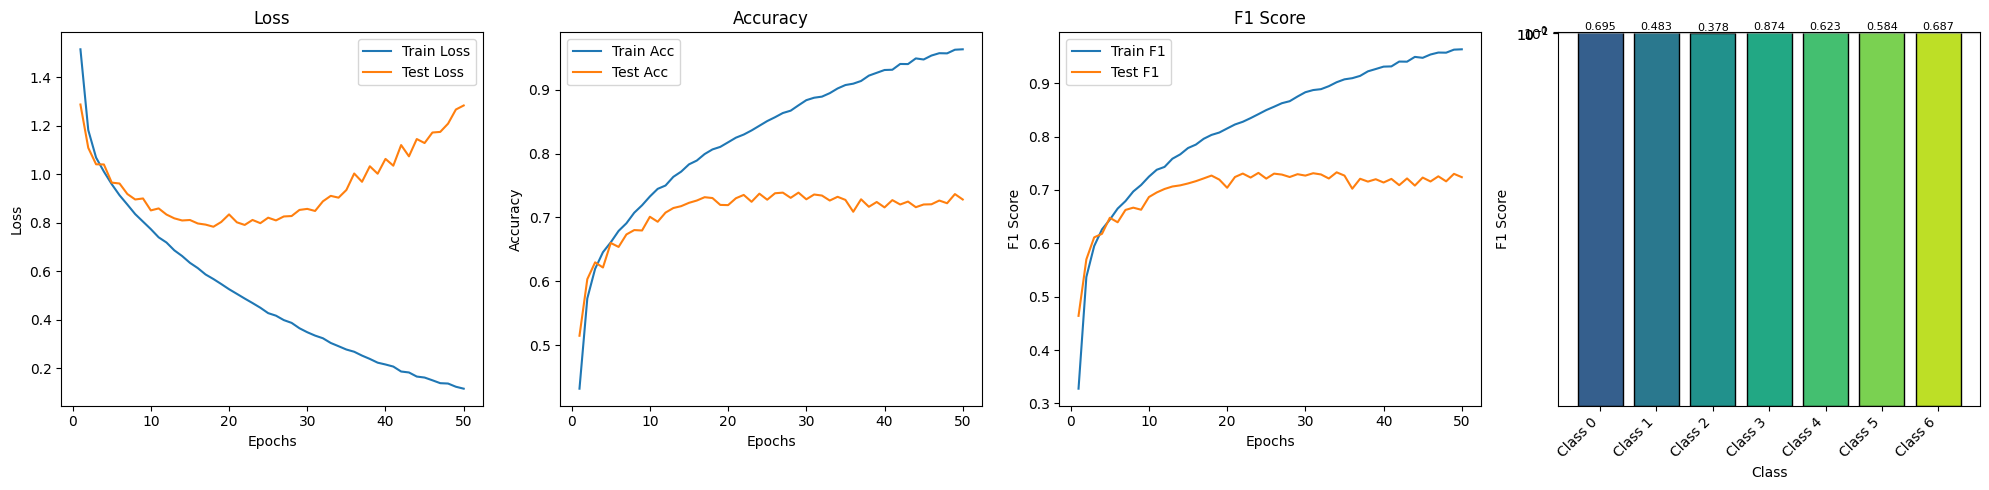

In [ ]:
class SimpleCNNModel2(nn.Module):
    # инициализация
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),#Делает карту принаков. Размер тензора (16, 100, 100)
            nn.ReLU(),#Слой активатор, все отрицательные веса становяться нулями
            nn.MaxPool2d(2, 2), #меняет размер тензора, размер становиться (16, 50, 50) 

            nn.Conv2d(16, 32, 3, 1, 1), # здесь размер тензора становиться (32, 50, 50)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # а тут (32, 25, 25)

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        H = img_size[0] // 8
        W = img_size[1] // 8
        dim = 64 * H * W 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
  
model = SimpleCNNModel2(img_size, 7).to(device)

n_epoch = 50
best_f1 = 0.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": [],
    "test_f1_per_class": []
}

for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1, train_f1_per_class = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1, test_f1_per_class = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)
    history["test_f1_per_class"].append(test_f1_per_class)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)


EPOCH 1/50
Epoch: 1, F1: 0.570

EPOCH 2/50
Epoch: 2, F1: 0.624

EPOCH 3/50
Epoch: 3, F1: 0.646

EPOCH 4/50
Epoch: 4, F1: 0.665

EPOCH 5/50
Epoch: 5, F1: 0.677

EPOCH 6/50

EPOCH 7/50
Epoch: 7, F1: 0.689

EPOCH 8/50
Epoch: 8, F1: 0.695

EPOCH 9/50
Epoch: 9, F1: 0.708

EPOCH 10/50
Epoch: 10, F1: 0.711

EPOCH 11/50

EPOCH 12/50

EPOCH 13/50

EPOCH 14/50

EPOCH 15/50
Epoch: 15, F1: 0.715

EPOCH 16/50
Epoch: 16, F1: 0.717

EPOCH 17/50
Epoch: 17, F1: 0.721

EPOCH 18/50
Epoch: 18, F1: 0.721

EPOCH 19/50

EPOCH 20/50
Epoch: 20, F1: 0.721

EPOCH 21/50

EPOCH 22/50

EPOCH 23/50

EPOCH 24/50

EPOCH 25/50

EPOCH 26/50

EPOCH 27/50

EPOCH 28/50

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50

EPOCH 34/50

EPOCH 35/50

EPOCH 36/50

EPOCH 37/50

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH 48/50

EPOCH 49/50

EPOCH 50/50
Best model: Epoch 20, F1: 0.721


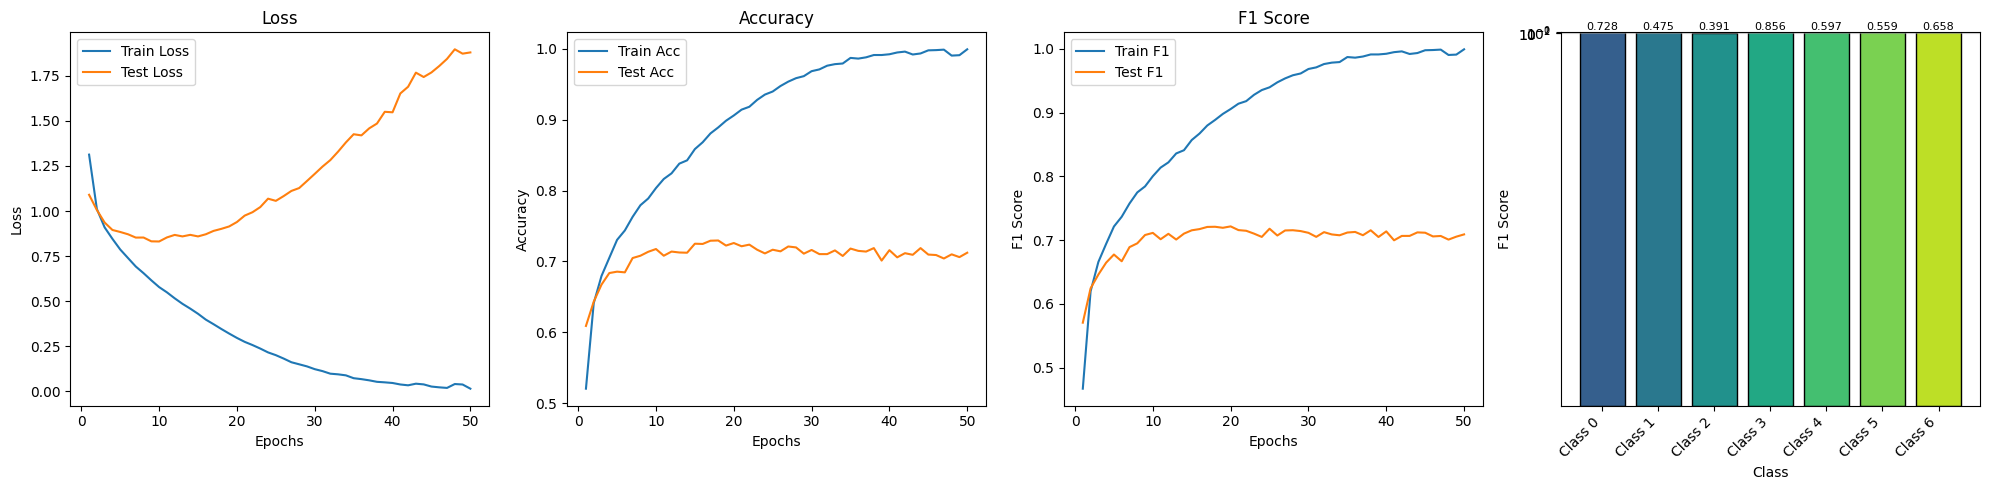

In [ ]:
class SimpleCNNModel3(nn.Module):
    # инициализация
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),#Делает карту принаков. Размер тензора (16, 100, 100)
            nn.ReLU(),#Слой активатор, все отрицательные веса становяться нулями
            nn.MaxPool2d(2, 2), #меняет размер тензора, размер становиться (16, 50, 50) 

            nn.Conv2d(32, 64, 3, 1, 1), # здесь размер тензора становиться (32, 50, 50)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # а тут (32, 25, 25)

            # nn.Conv2d(32, 64, 3, 1, 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2)
        )
        H = img_size[0] // 4
        W = img_size[1] // 4
        dim = 64 * H * W 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
img_size = (100, 100)
model = SimpleCNNModel3(img_size, 7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#переменные для кол-ва эпох и оценки
n_epoch = 50
best_f1 = 0.0

#история для создания графика
history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": [],
    "test_f1_per_class": []
}

#сам цикд обучения и цикл оценки
for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1, train_f1_per_class = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1, test_f1_per_class = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)
    history["test_f1_per_class"].append(test_f1_per_class)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)


EPOCH 1/50
Epoch: 1, F1: 0.575

EPOCH 2/50
Epoch: 2, F1: 0.631

EPOCH 3/50
Epoch: 3, F1: 0.646

EPOCH 4/50
Epoch: 4, F1: 0.666

EPOCH 5/50
Epoch: 5, F1: 0.671

EPOCH 6/50
Epoch: 6, F1: 0.674

EPOCH 7/50
Epoch: 7, F1: 0.695

EPOCH 8/50
Epoch: 8, F1: 0.703

EPOCH 9/50
Epoch: 9, F1: 0.705

EPOCH 10/50
Epoch: 10, F1: 0.708

EPOCH 11/50
Epoch: 11, F1: 0.712

EPOCH 12/50
Epoch: 12, F1: 0.717

EPOCH 13/50
Epoch: 13, F1: 0.724

EPOCH 14/50

EPOCH 15/50

EPOCH 16/50
Epoch: 16, F1: 0.728

EPOCH 17/50
Epoch: 17, F1: 0.734

EPOCH 18/50

EPOCH 19/50

EPOCH 20/50

EPOCH 21/50

EPOCH 22/50

EPOCH 23/50

EPOCH 24/50

EPOCH 25/50

EPOCH 26/50

EPOCH 27/50
Epoch: 27, F1: 0.736

EPOCH 28/50

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50

EPOCH 34/50

EPOCH 35/50

EPOCH 36/50

EPOCH 37/50

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH 48/50

EPOCH 49/50

EPOCH 50/50
Best model: Epoch 27, F1: 0.736


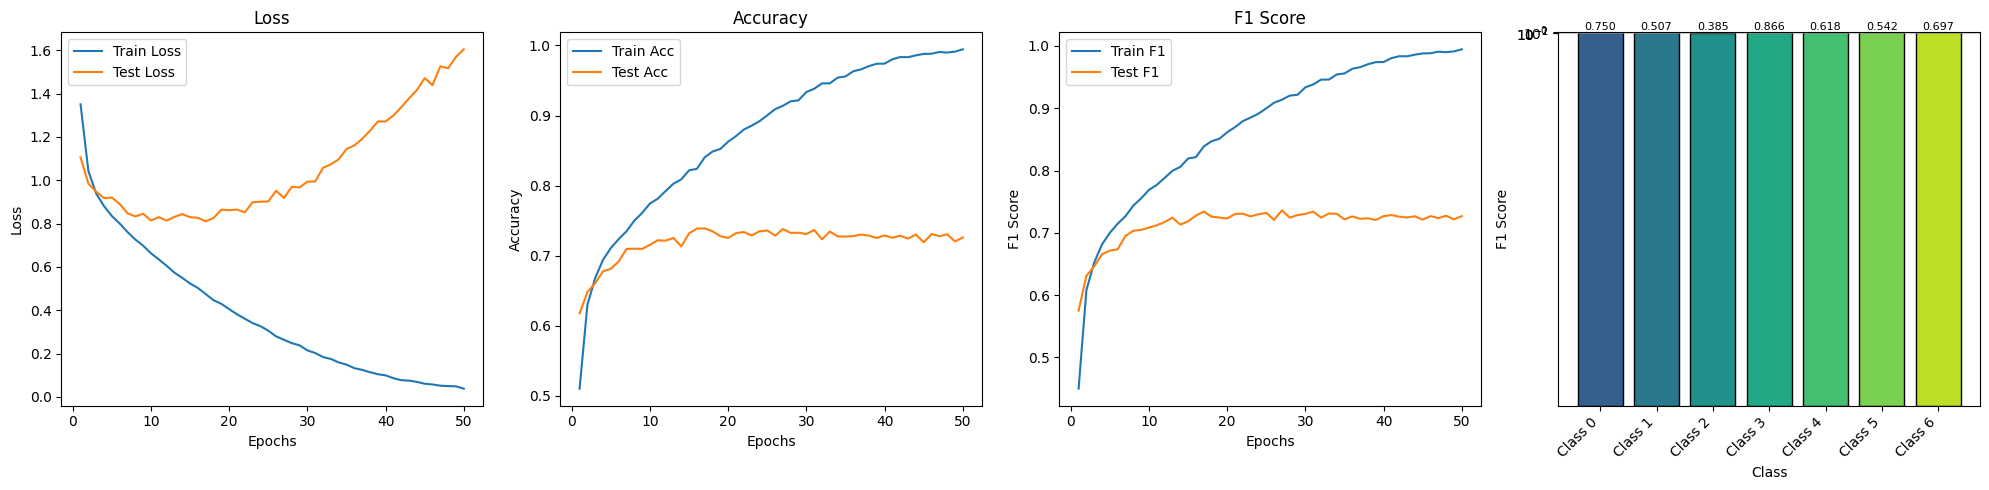

In [19]:
class SimpleCNNModel4(nn.Module):
    # инициализация
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),#Делает карту принаков. Размер тензора (16, 100, 100)
            nn.ReLU(),#Слой активатор, все отрицательные веса становяться нулями
            nn.MaxPool2d(2, 2), #меняет размер тензора, размер становиться (16, 50, 50) 

            nn.Conv2d(16, 32, 5, 1, 2), # здесь размер тензора становиться (32, 50, 50)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # а тут (32, 25, 25)

            # nn.Conv2d(32, 64, 3, 1, 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2)
        )
        H = img_size[0] // 4
        W = img_size[1] // 4
        dim = 32 * H * W 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
img_size = (100, 100)
model = SimpleCNNModel4(img_size, 7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#переменные для кол-ва эпох и оценки
n_epoch = 50
best_f1 = 0.0

#история для создания графика
history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": [],
    "test_f1_per_class": []
}

#сам цикд обучения и цикл оценки
for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1, train_f1_per_class = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1, test_f1_per_class = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)
    history["test_f1_per_class"].append(test_f1_per_class)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)

Справилась лучше всех 4 модель(в ноутбуку странные графики, когда писал код не в ноутбуке, графики были приятнее). Cnn справилась лучше fc. Т.к. в свёрточной модели мы создавали карту признаков, мы уменьшали сам тензор. В то рвемя как в Fc модели мы никаких опреаций не производили, прогнали через flatten и все.
Хороший прирост дал увелечение глубины нейросети и увелечение ядра. Думаю что сильный прирост может дать объединение этих признаков. Kernel_size с увелечением поглащает большее число параметров. Если раньше нужно было 9 весов, то сейчас идут 25 весов.

CNN + Dropout:


EPOCH 1/50
Epoch: 1, F1: 0.669

EPOCH 2/50
Epoch: 2, F1: 0.720

EPOCH 3/50
Epoch: 3, F1: 0.728

EPOCH 4/50
Epoch: 4, F1: 0.744

EPOCH 5/50
Epoch: 5, F1: 0.762

EPOCH 6/50
Epoch: 6, F1: 0.763

EPOCH 7/50
Epoch: 7, F1: 0.774

EPOCH 8/50
Epoch: 8, F1: 0.783

EPOCH 9/50

EPOCH 10/50
Epoch: 10, F1: 0.783

EPOCH 11/50
Epoch: 11, F1: 0.786

EPOCH 12/50

EPOCH 13/50
Epoch: 13, F1: 0.791

EPOCH 14/50

EPOCH 15/50
Epoch: 15, F1: 0.794

EPOCH 16/50

EPOCH 17/50

EPOCH 18/50

EPOCH 19/50

EPOCH 20/50
Epoch: 20, F1: 0.795

EPOCH 21/50

EPOCH 22/50

EPOCH 23/50

EPOCH 24/50

EPOCH 25/50

EPOCH 26/50

EPOCH 27/50

EPOCH 28/50

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50
Epoch: 33, F1: 0.795

EPOCH 34/50

EPOCH 35/50
Epoch: 35, F1: 0.796

EPOCH 36/50

EPOCH 37/50
Epoch: 37, F1: 0.797

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50
Epoch: 44, F1: 0.798

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH 48/50
Epoch: 48, F1: 0.799

EPOCH 49/50

E

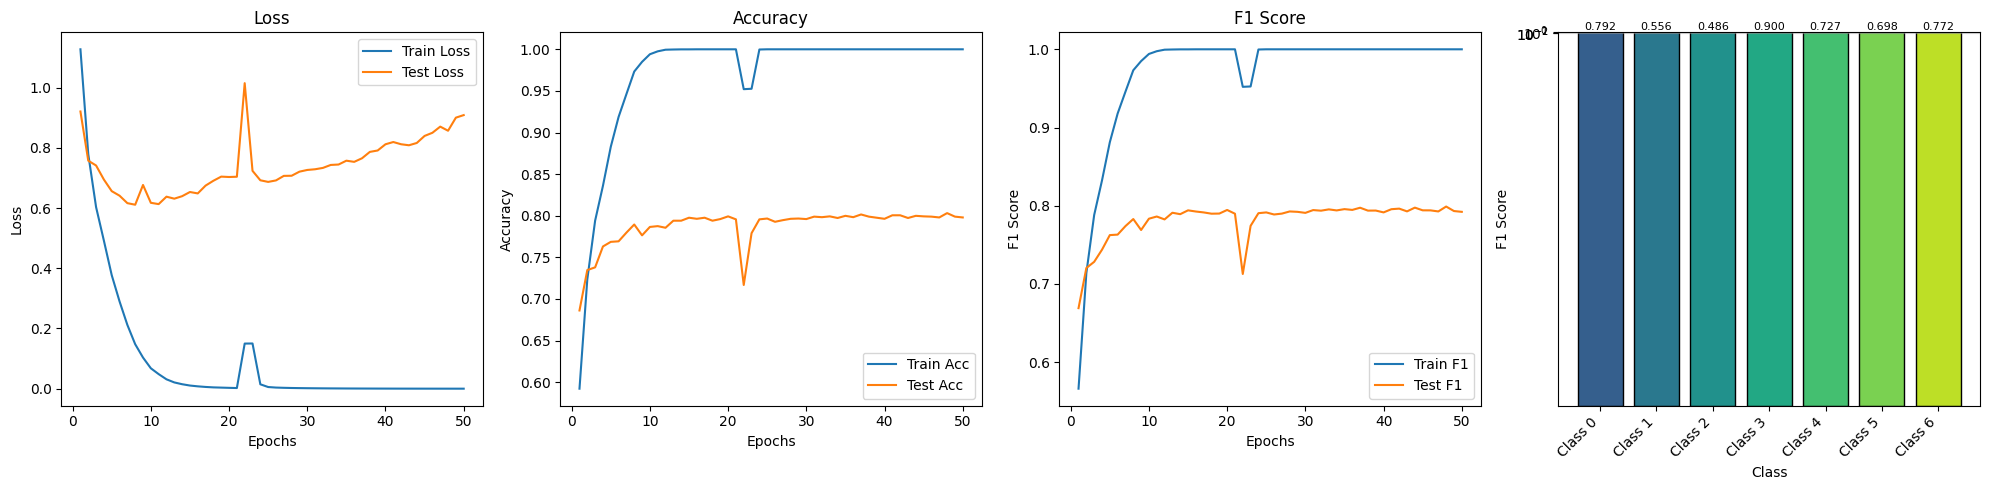

In [14]:
import torch.nn as nn
import torch.optim as optim
import torch as torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNNModelDropout(nn.Module):
    # инициализация
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 2),#Делает карту принаков. Размер тензора (32, 100, 100)
            nn.BatchNorm2d(32),
            nn.ReLU(),#Слой активатор, все отрицательные веса становяться нулями
            nn.MaxPool2d(2, 2), #меняет размер тензора, размер становиться (16, 50, 50)

            nn.Conv2d(32, 64, 5, 1, 2), # здесь размер тензора становиться (64, 50, 50)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # а тут (32, 25, 25)
            
            nn.Conv2d(64, 128, 5, 1, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        H = img_size[0] // 16
        W = img_size[1] // 16
        dim = 256 * H * W 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
img_size = (100, 100)
model = SimpleCNNModelDropout(img_size, 7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#переменные для кол-ва эпох и оценки
n_epoch = 50
best_f1 = 0.0

#история для создания графика
history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": [],
    "test_f1_per_class": []
}

#сам цикд обучения и цикл оценки
for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1, train_f1_per_class = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1, test_f1_per_class = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)
    history["test_f1_per_class"].append(test_f1_per_class)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)


EPOCH 1/50
Epoch: 1, F1: 0.628

EPOCH 2/50
Epoch: 2, F1: 0.666

EPOCH 3/50
Epoch: 3, F1: 0.717

EPOCH 4/50
Epoch: 4, F1: 0.727

EPOCH 5/50
Epoch: 5, F1: 0.750

EPOCH 6/50

EPOCH 7/50

EPOCH 8/50

EPOCH 9/50
Epoch: 9, F1: 0.774

EPOCH 10/50
Epoch: 10, F1: 0.774

EPOCH 11/50
Epoch: 11, F1: 0.787

EPOCH 12/50

EPOCH 13/50

EPOCH 14/50

EPOCH 15/50

EPOCH 16/50
Epoch: 16, F1: 0.793

EPOCH 17/50

EPOCH 18/50

EPOCH 19/50

EPOCH 20/50

EPOCH 21/50

EPOCH 22/50

EPOCH 23/50

EPOCH 24/50

EPOCH 25/50
Epoch: 25, F1: 0.798

EPOCH 26/50

EPOCH 27/50

EPOCH 28/50

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50

EPOCH 34/50

EPOCH 35/50

EPOCH 36/50

EPOCH 37/50

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH 48/50

EPOCH 49/50

EPOCH 50/50
Best model: Epoch 25, F1: 0.798


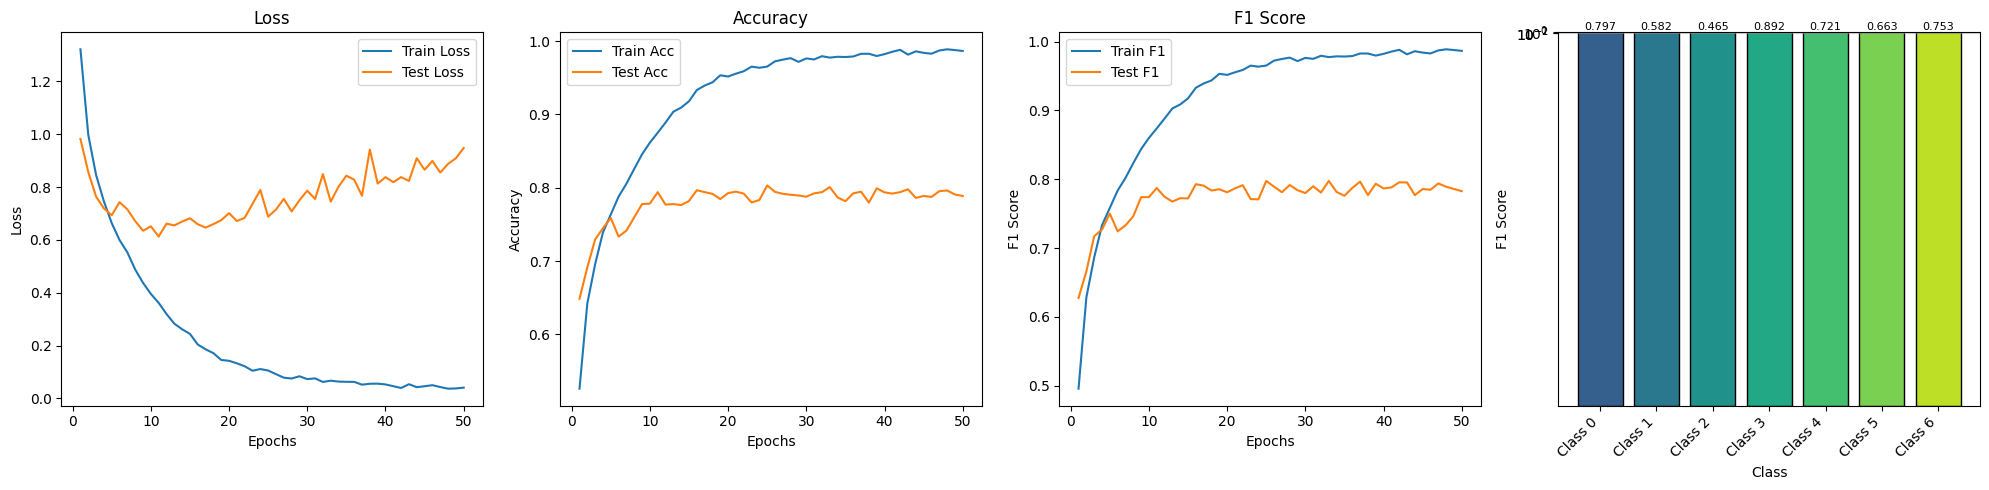

In [13]:
import torch.nn as nn
import torch.optim as optim
import torch as torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNNModelDropout(nn.Module):
    # инициализация
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 2),#Делает карту принаков. Размер тензора (32, 100, 100)
            nn.BatchNorm2d(32),
            nn.ReLU(),#Слой активатор, все отрицательные веса становяться нулями
            nn.MaxPool2d(2, 2), #меняет размер тензора, размер становиться (16, 50, 50)

            nn.Conv2d(32, 64, 5, 1, 2), # здесь размер тензора становиться (64, 50, 50)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # а тут (32, 25, 25)
            
            nn.Conv2d(64, 128, 5, 1, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )
        H = img_size[0] // 16
        W = img_size[1] // 16
        dim = 256 * H * W 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
img_size = (100, 100)
model = SimpleCNNModelDropout(img_size, 7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#переменные для кол-ва эпох и оценки
n_epoch = 50
best_f1 = 0.0

#история для создания графика
history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": [],
    "test_f1_per_class": []
}

#сам цикд обучения и цикл оценки
for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1, train_f1_per_class = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1, test_f1_per_class = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)
    history["test_f1_per_class"].append(test_f1_per_class)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)

Ответы на вопросы:
1. На графике из задания 2.2 виддно переобучение. Оно присутсвует, когда падают тестовые метрики. График f1 не равномерный, а скачущий.
2. BatchNormalization -- это процесс стабилизации и ускорения обучения, путем нормализации входов каждого слоя. У нас получаеться обучаться быстрее и стабильнее, так как веса становяться +- одинаковыми. Без стабилизации входные данные разыне, а с нормализацие одинаковые.
3. Dropout работает так, что он "отключает" некотрые нейроны, а оставшиеся обучаются интенсивнее.
4. Если бы во время оценки был бы включен dropout, то модель бы вела себя непредсказуемо. Давала бы разные ответы на одно и тоже изображение и т.д.
5. При случайном выключении нейрнов остальные нейроны становяться более сильными. За счет этого более сильные нейроны предотвращают переобучение.
Вопросы про графики(сравниваю графики, котрые получил в ноутбуке, но графики в ноутбуке очень сильно отличаються от графиков в коде):
1. Разрыв остаеться большим на метриках(если сравнивать графики не ноутбука, то разрыв удаёться минимизировать, в некотором роде тестовые метрики обгоняют тренировачные, но потом падают ближе 40 эпохе)
2. Итоговая метрика осталась та же(ноутбук). Итоговые метрики выросли, когда был добавлен dropout, а также был добавлен dropout2d на каждый слой(обычные графики)